# Introduction

A short notebook where we explore hair removal techniques on dermatoscopic images

## Import libraries

In [65]:
# Basic libraries
import os
import warnings
import cv2
from tqdm import tqdm 
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Load data

## Util functions

In [5]:
def show_images_in_line(folder_path, num_images=5, image_width=100, image_height=100):
    """
    Displays images from a folder in a single row using Matplotlib.

    :param folder_path: Path to the folder containing images.
    :param num_images: Number of images to display.
    :param image_width: Width to resize each image.
    :param image_height: Height to resize each image.
    """
    # Get list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    
    # Limit to the desired number of images
    image_files = image_files[:num_images]

    if not image_files:
        print("No images found in the folder.")
        return

    fig, axes = plt.subplots(1, len(image_files), figsize=(len(image_files) * 3, 3))

    # If only one image, make axes a list for uniformity
    if len(image_files) == 1:
        axes = [axes]

    for ax, file in zip(axes, image_files):
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)  # Read image with OpenCV
        if img is None:
            continue  # Skip unreadable images
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib
        img = cv2.resize(img, (image_width, image_height))  # Resize for consistency
        ax.imshow(img)
        ax.set_title(file)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

## Defining functions

In [41]:
def classify_skin_tone(ita_val):
    if ita_val > 55:
        return "Very Light"
    elif ita_val > 41:
        return "Light"
    elif ita_val > 28:
        return "Intermediate"
    elif ita_val > 10:
        return "Tan"
    elif ita_val > -30:
        return "Brown"
    else:
        return "Dark"



In [51]:
def predict_skin_color(image, mask):
    # Ensure mask has the same size as image
    if mask.shape[:2] != image.shape[:2]:
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    # Re-threshold after resizing to ensure binary values (0 or 1)
    _, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)

    skin_pixels = image[mask == 0]  # shape: (N_skin_pixels, 3)

    # Convert whole image to LAB
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    # Extract LAB values of skin pixels
    skin_lab = image_lab[mask == 0]
    
    # Compute mean LAB values
    mean_L, mean_A, mean_B = np.mean(skin_lab, axis=0)

    # ITA = arctangent((L - 50) / B) in degrees
    L = skin_lab[:, 0].astype(np.float32)
    B = skin_lab[:, 2].astype(np.float32)
    ita = np.arctan2((L - 50), B) * 180 / np.pi
    
    mean_ita = np.mean(ita)

    skin_tone_category = classify_skin_tone(mean_ita)
    
    return skin_tone_category



In [61]:
def process_image_batch(
    csv_file: str,
    image_dir: str,
    mask_dir: str,
    output_csv: str = "skin_tone_estimates.csv"
) -> None:
    """Loads images and masks, predicts skin tone category, and writes result to a new CSV."""
    df = pd.read_csv(csv_file)
    
    skin_tones = []

    for _, row in df.iterrows():
        base_name = row["image_name"]
        image_path = os.path.join(image_dir, base_name + ".jpg")
        mask_path = os.path.join(mask_dir, base_name + ".png")

        image = cv2.imread(image_path)
        if image is None:
            print(f"⚠️ Failed to load image: {image_path}")
            skin_tones.append(None)
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"⚠️ Failed to load mask: {mask_path}")
            skin_tones.append(None)
            continue

        try:
            tone = predict_skin_color(image, mask)
        except Exception as e:
            print(f"⚠️ Error processing {base_name}: {e}")
            tone = None

        skin_tones.append(tone)

    # Append results to the dataframe and save
    df["skin_tone"] = skin_tones
    df.to_csv(output_csv, index=False)
    print(f"✅ Saved updated CSV to {output_csv}")


## Processing and Evaluation

In [71]:
CSV_PATH = "/Users/mipopovic/Desktop/MunjeLumenDS2025/data/test_truth.csv"
IMAGE_FOLDER = "/Users/mipopovic/Desktop/MunjeLumenDS2025/data/test_output/train/benign/"
MASK_FOLDER = "/Users/mipopovic/Desktop/MunjeLumenDS2025/data/segmentation_mask/"
CSV_OUTPUT = "/Users/mipopovic/Desktop/MunjeLumenDS2025/data/skin_tone_estimates.csv"

In [72]:
process_image_batch(CSV_PATH,IMAGE_FOLDER,MASK_FOLDER, CSV_OUTPUT)

✅ Saved updated CSV to /Users/mipopovic/Desktop/MunjeLumenDS2025/data/skin_tone_estimates.csv


## Conclusion

In [74]:
def show_images_with_skin_tone(
    folder_path: str,
    csv_path: str,
    num_images: int = 5,
    image_width: int = 100,
    image_height: int = 100
):
    """
    Displays images from a folder in a row with their estimated skin tone from a CSV.

    :param folder_path: Path to folder with images.
    :param csv_path: Path to CSV containing 'image_name' and 'skin_tone' columns.
    :param num_images: Number of images to show.
    :param image_width: Resized width.
    :param image_height: Resized height.
    """
    # Load skin tone data
    df = pd.read_csv(csv_path)
    tone_dict = dict(zip(df["image_name"].astype(str) + ".jpg", df["skin_tone"]))

    # Gather image files
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    image_files = image_files[:num_images]

    if not image_files:
        print("No images found.")
        return

    fig, axes = plt.subplots(1, len(image_files), figsize=(len(image_files) * 3, 4))

    # Handle single image case
    if len(image_files) == 1:
        axes = [axes]

    for ax, filename in zip(axes, image_files):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is None:
            ax.axis("off")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (image_width, image_height))

        skin_tone = tone_dict.get(filename, "Unknown")

        ax.imshow(img)
        ax.set_title(filename, fontsize=9)
        ax.set_xlabel(f"Tone: {skin_tone}", fontsize=9)
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    plt.tight_layout()
    plt.show()


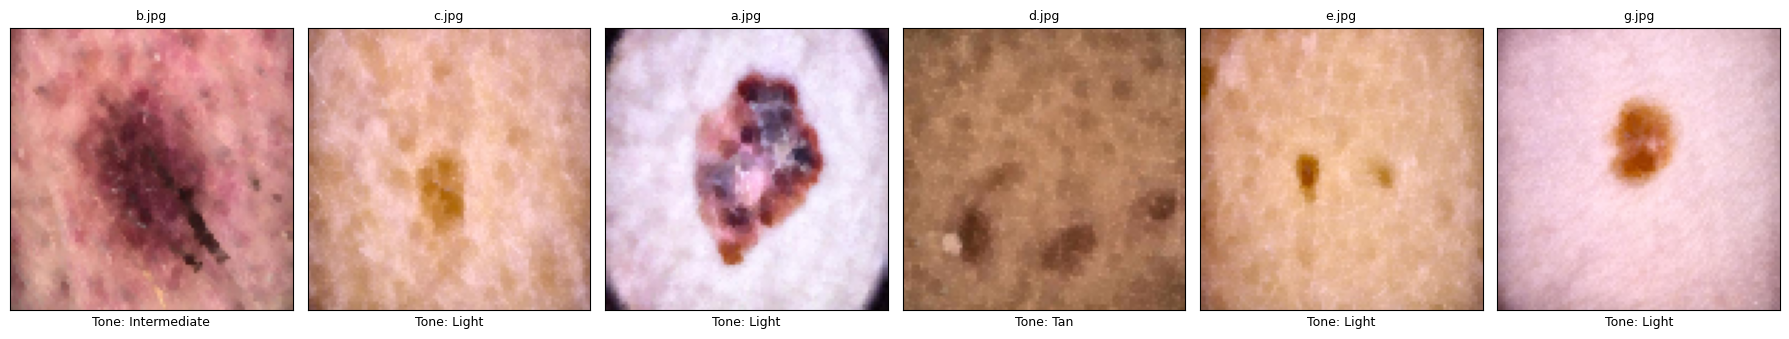

In [75]:
show_images_with_skin_tone(
    folder_path=IMAGE_FOLDER,
    csv_path=CSV_OUTPUT,
    num_images=6
)